In [1]:
import os
import glob
import sys
import numpy as np
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import torch as tr
import torch.nn as nn
import torch.optim as optim
from torch import distributions
from torch.nn.parameter import Parameter
print(sys.version)
dtype = tr.float64
tr.set_default_dtype(dtype)

3.12.6 (main, Sep  6 2024, 19:03:47) [Clang 16.0.0 (clang-1600.0.26.3)]


In [2]:
#O(3) generators
L  = tr.tensor([[[  0,  0,  0],
                 [  0,  0, -1],
                 [  0,  1,  0]],
                [[  0,  0,  1],
                 [  0,  0,  0],
                 [ -1,  0,  0]],
                [[  0, -1,  0],
                 [  1,  0,  0],
                 [ 0,  0,  0]]],dtype=dtype)

levi_civita = tr.zeros(3, 3, 3)
levi_civita[0, 1, 2] = levi_civita[1, 2, 0] = levi_civita[2, 0, 1] = 1
levi_civita[0, 2, 1] = levi_civita[2, 1, 0] = levi_civita[1, 0, 2] = -1

def mult(x,y):
    return x@y

#adjoint action
def ad(x,y):
    return x@y- y@x

def c(n):
        return 1.0/tr.math.factorial(n)

def expo(x,Ntaylor = 10):
    #horner scheme
    one = tr.eye(x.shape[0])
    #print(one)
    r = 1.0/tr.math.factorial(Ntaylor)*one
    for k in range(Ntaylor-1,0,-1):
        #print(k,r)
        r = r@x + 1.0/tr.math.factorial(k)*one
    #print(k,r)
    r = r@x + one
    #print(k,r)
    return r

def dexpo(x,y,Ntaylor = 10):
    #horner scheme
    r = (-1)**(Ntaylor%2)/tr.math.factorial(Ntaylor+1)*y
    for k in range(Ntaylor-1,0,-1):
        #print(k,r)
        r = ad(x,r) + (-1)**(k%2)/tr.math.factorial(k+1)*y
    #print(k,r)
    r = ad(x,r) + y
    #print(k,r)
    return r
    
def LieProject(x):
    x = 0.5*(x - x.T)
    return  x - 0.5*tr.eye(x.shape[0])*tr.trace(x)

def expo_so3(X):
    R = tr.eye(3)
    nX = X.norm()/np.sqrt(2)
    if (nX<tr.finfo(X.dtype).eps):
        return R
    return R + tr.sin(nX)/nX*X + (1-tr.cos(nX))/(nX*nX)*(X@X)

def dexpo_so3(X,Y):
    nX = X.norm()/np.sqrt(2)
    if (nX<tr.finfo(X.dtype).eps):
        return Y
    adj = ad(X,Y)
    nX2= nX**2
    return Y - (1-tr.cos(nX))/(nX2)*adj + (1 - tr.sin(nX)/nX)/(nX2) * ad(X,adj)


# rotation of v to u
def rotation(v,u):
    A = tr.einsum('s,r->sr',u,v) - tr.einsum('s,r->sr',v,u) 
    dd = tr.dot(u,v)
    return tr.eye(3) + A  + (A@A)/(1+dd)
    #return tr.eye(3) + A  + (A@A)*(1.0-dd)/(1-dd**2)

In [3]:
class PolyLayer(nn.Module):
    def __init__(self,cc):
        super(PolyLayer, self).__init__()
        self.cc =tr.nn.Parameter(tr.tensor(cc),requires_grad=True)
    def forward(self,x):
        val = tr.zeros_like(x)
        for k in range(self.cc.shape[0]-1):
            val = (val + self.cc[k])*x
        val+=self.cc[-1]
        return val
    def deriv(self,x):
        val = tr.zeros_like(x) 
        if(self.cc.shape[0]==1):
            return tr.zeros_like(x)
        N = self.cc.shape[0]-1.0
        for k in range(self.cc.shape[0]-2):
            val = (val + (N-k)*self.cc[k])*x
        val+=self.cc[-2]
        return val

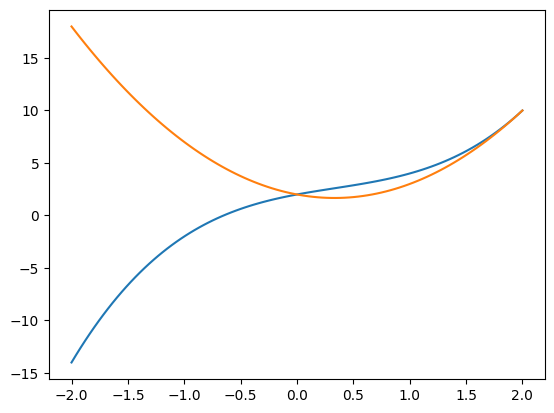

In [4]:
P = PolyLayer([1.0,-1.0,2.0,2.0])
xx = tr.linspace(-2,2,100)
#print(P(xx))
plt.plot(xx, P(xx).detach().numpy(),xx,P.deriv(xx).detach().numpy())

In [5]:
x = tr.randn(3,3)
x = LieProject(x)
y = tr.randn(3,3)
y = LieProject(y)

In [6]:
U = expo(x)

In [7]:
dU =dexpo(x,y)

In [8]:
U.T@U 

tensor([[ 1.0000e+00, -2.4373e-08,  1.2283e-08],
        [-2.4373e-08,  1.0000e+00,  6.4765e-09],
        [ 1.2283e-08,  6.4765e-09,  1.0000e+00]])

In [9]:
U

tensor([[ 0.8725,  0.3902,  0.2942],
        [-0.0044,  0.6084, -0.7937],
        [-0.4886,  0.6911,  0.5325]])

In [10]:
dU

tensor([[ 0.0000,  0.4815, -1.6832],
        [-0.4815,  0.0000, -1.0058],
        [ 1.6832,  1.0058,  0.0000]])

In [11]:
(expo(x,Ntaylor=10) - expo(x,Ntaylor=20)).norm()

tensor(5.4077e-08)

In [12]:
expo(x,Ntaylor=13)-expo_so3(x)

tensor([[ 5.0767e-12, -7.3668e-12,  4.4880e-12],
        [-7.9900e-12,  1.5591e-11,  8.6764e-13],
        [ 3.2515e-12,  3.2129e-12,  1.8611e-11]])

In [13]:
(dexpo(x,y,Ntaylor=10) - dexpo(x,y,Ntaylor=20)).norm()

tensor(9.4732e-09)

In [14]:
dexpo_so3(x,y)-dexpo(x,y,Ntaylor=19)

tensor([[ 0.0000e+00, -1.1102e-16,  2.2204e-16],
        [ 1.1102e-16,  0.0000e+00,  2.2204e-16],
        [-2.2204e-16, -2.2204e-16,  0.0000e+00]])

In [15]:
ad(x,ad(x,ad(x,y)))

tensor([[ 0.0000, -1.6918, -1.2271],
        [ 1.6918,  0.0000, -1.0965],
        [ 1.2271,  1.0965,  0.0000]])

In [16]:
(-1)**(10%2)

1

In [17]:
tt_dU = tr.eye(3) 
tt_dU += -1/tr.math.factorial(2) * ad(x,y) 
tt_dU += +1/tr.math.factorial(3) * ad(x,ad(x,y) )

In [18]:
tt_U = tr.eye(3) 
tt_U += 1/tr.math.factorial(1) * x
tt_U += 1/tr.math.factorial(2) * x@x
tt_U += 1/tr.math.factorial(3) * x@x@x


In [19]:
tt_U - expo(x,Ntaylor=3)

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0408e-17, 0.0000e+00, 0.0000e+00],
        [5.5511e-17, 0.0000e+00, 0.0000e+00]])

In [20]:
tt_dU - dexpo(x,y,Ntaylor=2)

tensor([[ 1.0000, -1.4325,  1.4241],
        [ 1.4325,  1.0000,  0.6165],
        [-1.4241, -0.6165,  1.0000]])

In [21]:
h=tr.randn(3)
s = tr.randn(3)
s = s/tr.norm(s)

In [22]:
h@s/tr.norm(h)

tensor(0.3773)

I am going to consider the partition function of a single spin $s$ in the external field $h$.
$$
Z[h] = \int ds e^{h\cdot s}
$$
where $s$ is a unit vector in $R^3$ and the measure $ds = \sin(\theta) d\theta d \phi$ with $\theta \in [0,\pi) $ and $\phi \in [0,2\pi)$.

This integral can be rewriten as
$$
Z[h] = 2\pi\int_{-1}^{1} dx e^{|h|x} = \int_{e^{-h}/h}^{e^h/h} d y = 4\pi \frac{\sinh(|h|)}{|h|}
$$
The map that trivializes the integral is
$$
y = \frac{e^{|h| x}}{|h|} = \frac{e^{|h| \cos(\theta)} }{|h|} 
$$

The expectation value of a spin is
$$
\langle s \rangle = \frac{1}{Z[h]} \int ds\; s\; e^{h\cdot s} = \left[\coth(|h|) - \frac{1}{|h|}\right] \hat h
$$
which we can sample via Monte Carlo by uniform sampling of the variable $y$. In the above $\hat h$ is the unit vector in the direction of $h$.

In [23]:
nh = tr.norm(h)
eh = tr.exp(-nh)

In [24]:
y = 2*tr.sinh(nh)/nh*tr.rand(100000000) + tr.exp(-nh)/nh
x = tr.log(y * nh )/nh
mx = x.mean().numpy()
ex = (x.std()/np.sqrt(y.shape[0])).numpy()
exact_x = (1/tr.tanh(nh)- 1/nh).numpy()
print("      <x> = ",mx,"+/-",ex)
print("exact <x> = ",exact_x)


      <x> =  0.43225777193623705 +/- 4.7601794772364844e-05
exact <x> =  0.43226368952125727


The above result confirms the analytic formula.
I will now try to find the map that trivializes the integral in a coordinate-independent manner. By following Luscher's trivializing map methodology it is easy to see that the flow action will be polynomial in $h\cdot h$ and $ h\cdot s$.
A continuous flow with generated by such flow action will result in a trivialization of the integral at hand. Therefore we will attempt to discover a discrete flow with 
rotation steps given by
$$
R = e^{\epsilon (hs^T - sh^T) f_p(h\cdot s, h\cdot h)}
$$
with $f_p$ a polynomium that depends on parameters $p$. I will now try to compute the jacobian of such transformation.

Let's consider that the spin $s$ is related by a rotation $R_0$ to some reference spin $v$. 
$$
 s = R_0 v = \left({\bf 1} + X_0 + X_0^2 \frac{1}{1+v^T s}\right)v
$$
where $X_0 = sv^T - vs^T$.

The Jacobian by such a transformation is given by
$$
J^{ab} = - \frac{1}{2}{\rm Tr}\left( \partial^b (R R_0) (R R_0)^T L^a \right)
$$

which results in
$$
J^{ab} = - \frac{1}{2}{\rm Tr}\left( \partial^b R R^T L^a \right) - \frac{1}{2}{\rm Tr}\left( R \partial^b R_0 R_0^T R^T L^a \right) 
$$
However, we have
$$
\partial^b R_0 = L^b R_0
$$
Remeber that in our formulation the primary variables are rotations not spins. Given thsi property of the rotation we have that
$$
\partial^b  s = \partial^b R_0 v = L^b R_0 v = L^b s
$$

Then the Jacobian matrix becomes
$$
J^{ab} = - \frac{1}{2}{\rm Tr}\left( \partial^b R R^T L^a \right) - \frac{1}{2}{\rm Tr}\left( R L^b R^T L^a \right) 
$$

In [25]:
P = PolyLayer([1.0,-1.0,2.0,2.0])
eps = 0.1
h = tr.randn(3)
s = tr.randn(3)
s = s/s.norm()
X = tr.einsum('a,b->ab',h,s)
X = LieProject(X)
X = eps*X*P(h@s)
dX = -tr.einsum('s,r,rka->ska',h,s,L)
dX = dX-dX.transpose(0,1)
dX = eps*dX*P(h@s) + tr.einsum('sr,k,kla,l->sra',X,h,L,s)*P.deriv(h@s)


In [26]:
s0 = tr.tensor([1.,0.,0.])
R0 = rotation(s0,s)
R = expo(X)

In [27]:
dexpo_dX = tr.zeros_like(L)
for a in range(3):
    dexpo_dX[:,:,a] = dexpo(X,dX[:,:,a])

In [28]:
J =-0.5*tr.einsum('sk,kla,ml,msb->ab',R0,L,R0,L) -0.5*tr.einsum('sk,kma,nm,nsb->ab',R,dexpo_dX,R,L)
J

tensor([[-0.0802, -0.7141, -1.4437],
        [-0.7720, -0.1435, -1.2375],
        [-0.2968, -1.0751, -0.3377]], grad_fn=<SubBackward0>)

In [29]:
tr.det(J)

tensor(-1.1101, grad_fn=<LinalgDetBackward0>)

In [30]:
h@s,h.norm()

(tensor(-0.8803), tensor(2.8945))

In [31]:
dexpo_L = tr.zeros_like(L)
for a in range(3):
    dexpo_L[:,:,a] = dexpo(X,L[:,:,a])

In [32]:
ttJ =-0.5*tr.einsum('sk,kla,ml,msb->ab',R0,L,R0,L) -0.5*tr.einsum('sra,rsb->ab',dX,dexpo_L)

In [33]:
tr.det(ttJ),tr.det(J)
# this confirms the two equivalent ways to compute the jacobian

(tensor(-1.1101, grad_fn=<LinalgDetBackward0>),
 tensor(-1.1101, grad_fn=<LinalgDetBackward0>))

In [34]:
def dexpo_func(a,X,Y):
    E =expo(a*X)
    return tr.einsum('ks,kl,lr->sr',E,Y,E)

In [35]:
Y = tr.randn(3,3)
Y = LieProject(Y)

In [36]:

a_points = np.linspace(0,1,1000)
S = 0.0
for a in list(a_points):
    S += dexpo_func(a,X,Y)

S -= 0.5*dexpo_func(0.,X,Y) + 0.5*dexpo_func(1.,X,Y)
S *= a_points[1] - a_points[0]

In [37]:
S

tensor([[ 5.2867e-20,  9.2179e-01,  1.7561e-01],
        [-9.2179e-01,  3.5988e-19, -1.3949e+00],
        [-1.7561e-01,  1.3949e+00,  2.7791e-19]], grad_fn=<MulBackward0>)

In [38]:
dexpo(X,Y)-S

tensor([[-5.2867e-20,  2.4520e-09,  1.3347e-10],
        [-2.4520e-09, -3.5988e-19, -3.0687e-09],
        [-1.3347e-10,  3.0687e-09, -2.7791e-19]], grad_fn=<SubBackward0>)

In [39]:
dexpo(X,Y,Ntaylor=20)-dexpo_so3(X,Y)

tensor([[ 0.0000e+00,  2.2204e-16,  1.1102e-16],
        [-2.2204e-16,  0.0000e+00,  0.0000e+00],
        [-1.1102e-16,  0.0000e+00,  0.0000e+00]], grad_fn=<SubBackward0>)

In [40]:
eps = 0.0001
dexpo_Y = (expo(X+eps*Y) - expo(X))/eps

In [41]:
expo(X)@dexpo(X,Y)-dexpo_Y
#yep my dexpo works!

tensor([[ 5.2233e-05, -2.2753e-05,  7.0890e-05],
        [-1.4973e-05,  1.3704e-04,  8.9547e-06],
        [ 6.0485e-05,  1.9310e-05,  9.2652e-05]], grad_fn=<SubBackward0>)

In [42]:
ad(X,Y)

tensor([[ 0.0000,  0.1161,  0.2186],
        [-0.1161,  0.0000,  0.1324],
        [-0.2186, -0.1324,  0.0000]], grad_fn=<SubBackward0>)

In [43]:
ad(X,ad(X,ad(X,Y))) + ad(X,Y)*X.norm()**2/2

tensor([[ 0.0000e+00,  0.0000e+00, -8.6736e-19],
        [ 0.0000e+00,  0.0000e+00, -8.6736e-19],
        [ 8.6736e-19,  8.6736e-19,  0.0000e+00]], grad_fn=<AddBackward0>)

This establishes that for $\mathfrak{so}(3)$
$$
ad_X^3(Y) = [X,[X,[X,Y]]] = -|X|_2^2 [X,Y]
$$
and
$$
ad_X^4(Y)  = -|X|_2^2 ad_X^2(Y), ad_X^5(Y)  = |X|_2^4 ad_X(Y)
$$

In general
$$
ad_X^{2k}(Y) = (-1)^{k-1} |X|_2^{2(k-1)} ad_X^2(Y)
$$
and
$$
ad_X^{2k+1}(Y) = (-1)^{k} |X|_2^{2k} ad_X(Y)
$$

I can use this to derive the closed for formula for
$$
\frac{1 - e^{-ad_X}}{ad_X} = {\bf 1} - \frac{1 - \cos(|X|)}{|X|^2} X + \frac{1 - \frac{\sin(|X|)}{|X|}}{|X|^2} X^2
$$

In addition the exact exponentiation is
$$
e^X = {\bf 1} + \frac{\sin(|X|)}{|X|} X + \frac{1-\cos(|X|)}{|X|^2} X^2 = {\bf 1} + \frac{\sin(|X|)}{|X|} X + \frac{2\sin^2(\frac{|X|}{2})}{|X|^2} X^2 
$$

In the above $|X|$ is the the $l-2$ norm of $X$ which is $ |X|_{fro}/\sqrt{2}$  where $ |X|_{fro}$ is the Frobenius norm of $X$. It turns out that for $X \in \mathfrak{so}(3)$ $|X|_{fro} = |X|_2$.
Note that there is no singularity at $|X|=0$ however, numerical implementation needs to handle this point.
I set $e^X = {\bf 1}$ if  $|X|<\epsilon$ with $\epsilon$ being the machine precision. Also not that torch returns the Frobenius norm of a matrix.

Note that $|X|^2 = \sum_a X_a^2$ with $X_a = -\frac{1}{2}\, Tr( X L^a)$ 

See https://ethaneade.com/exp_diff.pdf for details

Also a comprehensive paper is: 
https://www.researchgate.net/publication/376116615_Highly_accurate_differentiation_of_the_exponential_map_and_its_tangent_operator

These papers have interesting formulas although I do not understand thier notation.

In [44]:
xx = -0.5*tr.einsum('sk,ksa->a',X,L)

In [45]:
xx

tensor([0.0795, 0.1040, 0.1051], grad_fn=<MulBackward0>)

In [46]:
-tr.norm(xx)**2*ad(X,Y) - ad(X,ad(X,ad(X,Y)))

tensor([[-0.0000e+00, -4.3368e-19,  0.0000e+00],
        [ 4.3368e-19, -0.0000e+00,  4.3368e-19],
        [ 0.0000e+00, -4.3368e-19, -0.0000e+00]], grad_fn=<SubBackward0>)

The notebook checks up to here. 


Be careful that in python
<p>
<b>
(L[a]@s).T = (L[a]@s) 
</b>
</p>
which I thought should be 
<p>
<b>
(L[a]@s).T = s.T@L[a].T = -s.T@L[a]
</b>
</p>
due to the anti-symmetry of the generators $L$. The problem is that in python <b>s=s.T</b>.

However, by using einsum and proper index manipulations... all mathematical formulas work just fine.

The remaining of the problems where just minor bugs.

In [47]:
def x_rot_map(s,h,dt,f):
    X = tr.einsum('s,r->sr',h,s)
    X = X-X.transpose(0,1)
    return dt*f(h@s)*X
def dx_rot_map(s,h,dt,f):
    xX = tr.einsum('s,r->sr',h,s) - tr.einsum('s,r->sr',s,h)
    dX = -tr.einsum('s,r,rka->ska',h,s,L) - tr.einsum('ska,k,r->sra',L,s,h)
    #print(dX)
    #print(dX.transpose(0,1))
    #dX = dX-dX.transpose(0,1)
    #print(dX)
    dX=dX*f(h@s) + tr.einsum('sr,k,kla,l->sra',xX,h,L,s)*f.deriv(h@s)
    return dt*dX
def rot_map(s,h,dt,f):
    return expo_so3(x_rot_map(s,h,dt,f))


In [48]:
#P=PolyLayer([3.,2.,1.0]) 
P=PolyLayer([.3,.2,0.]) 
Rm= rot_map(s,h,0.25,P)
X = x_rot_map(s,h,0.25,P)

In [49]:
eps=1.0e-5
d_rot_map_1 = tr.zeros_like(L)
d_rot_map_2 = tr.zeros_like(L)
dX_num_1 = tr.zeros_like(L)
dX_num_2 = tr.zeros_like(L)
Rm_p = tr.zeros_like(L)
Rm_m = tr.zeros_like(L)
for a in range(3):
    sp = expo(eps*L[:,:,a])@s
    sm = expo(-eps*L[:,:,a])@s
    d_rot_map_2[:,:,a]= 0.5* (rot_map(sp,h,0.25,P) - rot_map(sm,h,0.25,P))/eps
    d_rot_map_1[:,:,a]=      (rot_map(sp,h,0.25,P) - rot_map(s,h,0.25,P))/eps
    dX_num_1[:,:,a] = (x_rot_map(sp,h,0.25,P) - x_rot_map(s,h,0.25,P))/eps
    dX_num_2[:,:,a] =0.5* (x_rot_map(sp,h,0.25,P) - x_rot_map(sm,h,0.25,P))/eps
    Rm_p[:,:,a] = rot_map(sp,h,0.25,P) 
    Rm_m[:,:,a] = rot_map(sm,h,0.25,P) 
                   
dX = dx_rot_map(s,h,0.25,P)    

In [50]:
d_rot_map_1-d_rot_map_2

tensor([[[-4.1654e-07, -5.9508e-07, -7.8231e-07],
         [ 1.8400e-06,  1.4113e-06,  4.4836e-06],
         [-9.0058e-07, -2.0988e-06, -3.3017e-06]],

        [[-1.6213e-06, -7.7768e-07, -3.9831e-06],
         [-2.8538e-07, -5.6826e-07, -5.7769e-07],
         [-5.1947e-07,  4.9963e-06,  1.7556e-06]],

        [[ 1.1450e-06,  2.6874e-06,  3.8304e-06],
         [ 9.3525e-07, -4.4015e-06, -9.7394e-07],
         [-2.4770e-07, -6.2381e-07, -5.3796e-07]]], grad_fn=<SubBackward0>)

In [51]:
print("Numerical check of dX: ",tr.norm(dX_num_2 - dX)/tr.norm(dX))
#dX_num_1[:,:,2],dX_num_2[:,:,2],dX[:,:,2]
# test passed

Numerical check of dX:  tensor(1.4892e-10, grad_fn=<DivBackward0>)


In [52]:
X  =  x_rot_map(s,h,0.25,P)
dX = dx_rot_map(s,h,0.25,P)
Rm =    rot_map(s,h,0.25,P)
d_rot_map_ex = tr.zeros_like(L)
for a in range(3):
    d_rot_map_ex[:,:,a] = Rm@dexpo(X,dX[:,:,a])

In [53]:
d_rot_map_ex[:,:,0]-d_rot_map_1[:,:,0]

tensor([[ 4.1655e-07, -1.8400e-06,  9.0055e-07],
        [ 1.6213e-06,  2.8538e-07,  5.1951e-07],
        [-1.1450e-06, -9.3529e-07,  2.4770e-07]], grad_fn=<SubBackward0>)

In [54]:
d_rot_map_ex[:,:,0]-d_rot_map_2[:,:,0]

tensor([[ 5.6568e-12,  2.4859e-11, -3.0295e-11],
        [-2.3921e-11,  3.4839e-14,  3.4863e-11],
        [ 3.0215e-11, -3.9660e-11,  6.7246e-13]], grad_fn=<SubBackward0>)

In [55]:
print("Numerical check of dX: ",tr.norm(dX_num_2 - dX)/tr.norm(dX))

Numerical check of dX:  tensor(1.4892e-10, grad_fn=<DivBackward0>)


<u><b> New try </b></u>

I want to compute the differential of a rotation matrix given by:
$$
 R = e^X
$$
where 
$$
X = (hs^T - sh^T) f(s\cdot h,h\cdot h)
$$

We know that 
$$
d R = \int_0^1 dt e^{(1-t) X} dX e^{tX}  = e^X \int_0^1 dt e^{-t X} dX e^{tX}
$$

However, we know that

$$
{\rm dexp}(X)Y = \int_0^1 da e^{-a X} Y e^{aX}
$$


Therefore
$$
d R =  e^X  {\rm dexp}(X) dX  = R {\rm dexp}(X) dX 
$$

I will integrate numerically the formula above to computer $d R$ as a check but also use the $\rm dexp$ formula with the implementation of $\rm dexp$ from earlier in the notebook.

We can easily check that
$$
d R = \int_0^1 dt e^{(1-t) X} dX e^{tX}  = \int_0^1 dt e^{t X} dX e^{(1-t)X} = \int_0^1 dt e^{t X} dX e^{-tX} e^X 
$$
or
$$
d R =  e^X  {\rm dexp}(X) dX   =   {\rm dexp}(-X)dX\,\,\,  e^X 
$$


In [56]:
def integal_formula_dR(s,h,dt,f,N=100):
    X = x_rot_map(s,h,dt,f)
    dX = dx_rot_map(s,h,dt,f)
    def ff(t):
        foo = tr.empty_like(dX)
        E1= expo_so3((1.0-t)*X)
        E0 = expo_so3(t*X)
        for a in range(dX.shape[2]):
            foo[:,:,a] =  E1 @ dX[:,:,a] @ E0
            #foo[:,:,a] =  E0 @ dX[:,:,a] @ E1
        return foo

    I = 0.5*(ff(0) + ff(1))
    time = np.linspace(0.0,1.0,N+1)
    #print(time)
    for t in time[1:time.shape[0]-1]:
        I += ff(t)
    return I*(time[1]-time[0])

def numerical_dR(s,h,dt,f,eps=1.0e-3):
    #R = expo_so3(rot_map(s,h,dt,f))
    R_p = tr.zeros(3,3,3)
    R_m = tr.zeros(3,3,3)
    for a in range(3):
        sp = expo_so3(eps*L[:,:,a])@s
        sm = expo_so3(-eps*L[:,:,a])@s
        #sp = expo_so3(eps*L[:,a,:])@s
        #sm = expo_so3(-eps*L[:,a,:])@s
        R_p[:,:,a] = rot_map(sp,h,dt,f) 
        R_m[:,:,a] = rot_map(sm,h,dt,f) 
    return 0.5*(R_p - R_m)/eps

def dexpo_formula_dR(s,h,dt,f):
    X = x_rot_map(s,h,dt,f)
    dX = dx_rot_map(s,h,dt,f)
    dR=tr.empty(3,3,3)
    for a in range(dX.shape[2]):
        dR[:,:,a] = expo_so3(X)@dexpo_so3(X,dX[:,:,a])
    return dR

def dexpo_formula_dR_m(s,h,dt,f):
    X = x_rot_map(s,h,dt,f)
    dX = dx_rot_map(s,h,dt,f)
    dR=tr.empty(3,3,3)
    for a in range(dX.shape[2]):
        dR[:,:,a] = dexpo_so3(-X,dX[:,:,a])@expo_so3(X)
    return dR

In [57]:
if ( False ):
# my expo is faster...  both the exact and the taylor. My taylor seems more accurate 
    %timeit tr_expo = tr.matrix_exp(x_rot_map(s,h,.25,P))
    %timeit my_expo = expo(x_rot_map(s,h,.25,P))
    %timeit so3_expo = expo_so3(x_rot_map(s,h,.25,P))
    tr_expo = tr.matrix_exp(x_rot_map(s,h,.25,P))
    my_expo = expo(x_rot_map(s,h,.25,P))
    so3_expo = expo_so3(x_rot_map(s,h,.25,P))

    print(tr.norm(my_expo-so3_expo)/tr.norm(so3_expo),tr.norm(tr_expo-so3_expo)/tr.norm(so3_expo))

In [58]:
dR = integal_formula_dR(s,h,0.25,P,N=1000)
num_dR = numerical_dR(s,h,0.25,P,eps=1e-6)
dexpo_dR = dexpo_formula_dR(s,h,0.25,P)
dexpo_dR_m = dexpo_formula_dR_m(s,h,0.25,P)

In [59]:
print("Difference from numerical formula  : ",tr.norm(dR- num_dR)/tr.norm(dR))
print("Difference from dexpo     formula  : ",tr.norm(dR- dexpo_dR)/tr.norm(dR))
print("Difference from dexpo_m   formula  : ",tr.norm(dR- dexpo_dR_m)/tr.norm(dR))
print("\nDifference dexpo - dexpo_m formula  : ",tr.norm(dexpo_dR_m - dexpo_dR)/tr.norm(dexpo_dR))

Difference from numerical formula  :  tensor(1.1836e-10, grad_fn=<DivBackward0>)
Difference from dexpo     formula  :  tensor(8.3962e-12, grad_fn=<DivBackward0>)
Difference from dexpo_m   formula  :  tensor(8.3963e-12, grad_fn=<DivBackward0>)

Difference dexpo - dexpo_m formula  :  tensor(2.1310e-16, grad_fn=<DivBackward0>)


In [60]:
#success!

<u><b>Check the formulas for the Jacobian</b></u>

As mentioned above:
$$
J^{ab} = - \frac{1}{2}{\rm Tr}\left( \partial^b R R^T L^a \right) - \frac{1}{2}{\rm Tr}\left( R L^b R^T L^a \right) = - \frac{1}{2}{\rm Tr}\left( R {\rm dexpo}(X) dX^b R^T L^a \right) - \frac{1}{2}{\rm Tr}\left( R L^b R^T L^a \right)
$$
This now becomes:
$$
J^{ab} =  - \frac{1}{2}{\rm Tr}\left(  {\rm dexpo}(-X) dX^b R R^T L^a \right) - \frac{1}{2}{\rm Tr}\left( R L^b R^T L^a \right)
$$

or
$$
J^{ab} =  - \frac{1}{2}{\rm Tr}\left(  {\rm dexpo}(-X) dX^b L^a \right) - \frac{1}{2}{\rm Tr}\left( R L^b R^T L^a \right)
$$

Let's break up the two contributions as
$$
J^{ab}_1 =  - \frac{1}{2}{\rm Tr}\left[  {\rm dexpo}(-X) dX^b L^a \right]  = \frac{1}{2}{\rm Tr}\left[ dX^b \left({\rm dexpo}(X)L^a\right)^T \right] 
$$
$$
J^{ab}_2 = - \frac{1}{2}{\rm Tr}\left( R L^b R^T L^a \right)
$$

First I will explicitly compute these terms.

In [61]:
# J_1 term:
def J_1(s,h,dt,f):
    jJ_1 = tr.zeros(3,3)
    X = x_rot_map(s,h,dt,f)
    dX = dx_rot_map(s,h,dt,f)
    for a in range(3):
        for b in range(3):
             jJ_1[a,b] = -0.5*tr.trace(dexpo_so3(-X,dX[:,:,b])@L[:,:,a])
    return jJ_1

def J_1_alt(s,h,dt,f):
    jJ_1 = tr.zeros(3,3)
    X = x_rot_map(s,h,dt,f)
    dX = dx_rot_map(s,h,dt,f)
    for a in range(3):
        for b in range(3):
             jJ_1[a,b] = 0.5*tr.trace(dX[:,:,b]@(dexpo_so3(X,L[:,:,a])).T)
    return jJ_1
    
def J_1_explicit(s,h,dt,f):
    jJ_1 = tr.zeros(3,3)
    X = x_rot_map(s,h,dt,f)
    dX = dx_rot_map(s,h,dt,f)
    dR = dexpo_formula_dR(s,h,dt,f)
    R = expo_so3(X)
    for a in range(3):
        for b in range(3):
            jJ_1[a,b] = -0.5*tr.trace(dR[:,:,b]@R.T@L[:,:,a])
    return jJ_1


def J_2(s,h,dt,f):
    R = expo_so3(x_rot_map(s,h,dt,f))
    return -0.5*tr.einsum('sr,rlb,kl,ksa->ab',R,L,R,L)

def J_2_old(s,h,dt,f):
    R = expo_so3(x_rot_map(s,h,dt,f))
    J2 = tr.zeros(3,3)
    for a in range(3):
        for b in range(3):
            J2[a,b] = -0.5*tr.trace(R@L[:,:,b]@R.T@L[:,:,a])
    return J2

def J(s,h,dt,f):
    return J_1(s,h,dt,f) + J_2(s,h,dt,f)

In [62]:
jj_1 = J_1(s,h,0.25,P)
jj_1_exp = J_1_explicit(s,h,0.25,P)
jj_1_alt = J_1_alt(s,h,0.25,P)
jj_2 = J_2(s,h,0.25,P)
jjj_2 = J_2_old(s,h,0.25,P)
(jjj_2 - jj_2).norm()

tensor(1.1108e-16, grad_fn=<LinalgVectorNormBackward0>)

In [63]:
tr.linalg.det(jj_1+jj_2)

tensor(0.3931, grad_fn=<LinalgDetBackward0>)

In [64]:
def checks(s,h,dt,f):
    jJ_1 = tr.zeros(3,3)
    X = x_rot_map(s,h,dt,f)
    dX = dx_rot_map(s,h,dt,f)
    dR = dexpo_formula_dR(s,h,dt,f)
    R = expo_so3(X)
    for a in range(3):
        print(a," dR@R.T diff: ",tr.norm( dR[:,:,a]@R.T - dexpo_so3(-X,dX[:,:,a])) )

    for a in range(3):
        print(a," dR  diff: ",tr.norm( dR[:,:,a]-  R@dexpo_so3(X,dX[:,:,a])) )

if (False):
    checks(s,h,0.25,P)

In [65]:
(jj_1-jj_1_exp).norm(),(jj_1-jj_1_alt).norm()

(tensor(1.6184e-16, grad_fn=<LinalgVectorNormBackward0>),
 tensor(6.2063e-17, grad_fn=<LinalgVectorNormBackward0>))

<u><b>Further Manipulations</b></u>


Let $X_a = -\frac{1}{2} {\rm Tr}(L^a X)$

Then $X = \sum_a X_a L^a$

With this we can show that
$$
ad_X L^a = -\sum_{bc} L^c \epsilon_{cab} X_b
$$

Defining:
$$
[ad_X]_{ab} = -  \sum_{c}  \epsilon_{abc} X_c 
$$

we can write:
$$
ad_X L^a = \sum_{c} L^c [ad_X]_{ca}
$$

Let's now define the matrix
$$
dX^b_a = -\frac{1}{2} {\rm Tr}(dX^b L^a) = (h^T L^a L^b s) f(s\cdot h) + (h^TL^as) (h^T L^b s) f'(s\cdot h) 
$$

and
$$
dX^b = \sum_a dX^b_a L^a
$$

We can also compute:
$$
[dE_X]_{ab} = [dexp(X)L^a]_b = -\frac{1}{2}{\rm Tr}(dexp(X)L^a L^b) = \delta_{a,b} + \frac{1 - \cos(|X|)}{|X|^2} [ad_X]_{ab} + \frac{1 - \frac{\sin(|X|)}{|X|}}{|X|^2} ([ad_X][ad_X])_{ab}
$$

With this definition:
$$
 dexp(X)L^a = \sum_b [dE_X]_{ab} L^b
$$

and as a result:
$$
J^{ab}_1  = \frac{1}{2}{\rm Tr}\left[ dX^b \left(\sum_c [dE_X]_{ac} L^c\right)^T \right]  = - \frac{1}{2}{\rm Tr}\left[ \sum_d dX^b_d L^d \sum_c [dE_X]_{ac} L^c\right] = \sum_c dX^b_c [dE_X]_{ac}
$$
or
$$
J^{ab}_1  = \left([dX] [dE_X]^T \right)^{ba}
$$

In [66]:
# check the component formula
cX = tr.tensor([-0.5 * tr.trace(L[:,:,a]@X) for a in range(3)])
print("Component formula checks if zero: ",tr.norm(tr.einsum('a,...a->...',cX,L)- X).detach().numpy().item())

Component formula checks if zero:  0.0


In [67]:
def adX_mat_v0(X):
    cX = tr.tensor([-0.5 * tr.trace(L[:,:,a]@X) for a in range(3)])
    AdX = -tr.einsum('abc,c->ab',levi_civita,cX)
    return AdX

def adX_mat(X):
    return 0.5*tr.einsum('abc,rsc,sr->ab',levi_civita,L,X)

#check ad_X formula
def checks_adX(s,h,dt,f):
    X = x_rot_map(s,h,dt,f)
    cX = tr.tensor([-0.5 * tr.trace(L[:,:,a]@X) for a in range(3)])
    #AdX = -tr.einsum('abc,c->ab',levi_civita,cX)
    AdX = adX_mat(X)
    #print(AdX)
    matrix_ad = tr.einsum('...c,ca->...a',L,AdX)
    matrix_ad2 = tr.einsum('...c,ca->...a',L,AdX@AdX)
    explicit_ad = tr.zeros_like(matrix_ad)
    explicit_ad2 = tr.zeros_like(matrix_ad)
    for a in range(3):
        explicit_ad[:,:,a] = ad(X,L[:,:,a])
        explicit_ad2[:,:,a] = ad(X,ad(X,L[:,:,a]))
    print("Check two versions of AdX: ",(adX_mat_v0(X) - adX_mat(X)).norm().detach().item())
    print("\n")
    print("Check matrix adjoint   formula: ",(explicit_ad-matrix_ad).norm().detach().item())
    print("Check matrix adjoint^2 formula: ",(explicit_ad2-matrix_ad2).norm().detach().item())

In [68]:
checks_adX(s,h,0.25,P)

Check two versions of AdX:  0.0


Check matrix adjoint   formula:  0.0
Check matrix adjoint^2 formula:  3.0665868333667484e-19


In [69]:
def dX_matrix(s,h,dt,f):
    dX = dx_rot_map(s,h,dt,f)
    return -0.5*tr.einsum('rsb,sra->ba',dX,L)

def dX_matrix_spin(s,h,dt,f):
    sh = s@h
    ffo = tr.einsum('s,ska,krb,r->ba',h,L,L,s) *f(sh)
    #ffo = ffo+ffo.T
    hLs = tr.einsum('s,sra,r->a',h,L,s)
    return dt*(ffo + tr.outer(hLs,hLs)*f.deriv(sh))

# 
def dX_matrix_spin2(s,h,dt,f):
    dX_ba =  tr.einsum('r,rka,ksb,s->ba',h,L,L,s)
    #foo = tr.einsum('k,kla,l->a',h,L,s)
    #dX=dX_ba*f(h@s) + tr.einsum('a,b->ab',foo,foo)*f.deriv(h@s)
    dX=dX_ba*f(h@s) + tr.einsum('k,kla,l,m,mnb,n->ab ',h,L,s,h,L,s)*f.deriv(h@s)
    return dt*dX
    
#just for checking algebra
def dx_rot_map_and_matrix(s,h,dt,f):
    xX = tr.einsum('s,r->sr',h,s) - tr.einsum('s,r->sr',s,h)
    dX = -tr.einsum('s,r,rka->ska',h,s,L) - tr.einsum('ska,k,r->sra',L,s,h)
    term1 = -0.5*tr.einsum('srb,rsa->ba',dX,L)*f(h@s)*dt
    #tt_term1 = 0.5*f(h@s)*dt*(tr.einsum('...b,...a->ba',
    #    (tr.einsum('s,r,rka->ska',h,s,L) + tr.einsum('ska,k,r->sra',L,s,h)),L))
    
    #tt_term1 = -0.5*f(h@s)*dt*(tr.einsum('s,r,rkb,ksa->ba',h,s,L,L) + tr.einsum('skb,k,r,rsa->ba',L,s,h,L))
    #tt_term1 = -0.5*f(h@s)*dt*(tr.einsum('r,rkb,ksa,s->ba',s,L,L,h) + tr.einsum('r,rsa,skb,k->ba',h,L,L,s))
    tt_term1 = f(h@s)*dt*tr.einsum('r,rkb,ksa,s->ba',s,L,L,h)
    print((tt_term1-term1).norm())
    #print(tt_term1,term1)
    #print(dX)
    #print(dX.transpose(0,1))
    #dX = dX-dX.transpose(0,1)
    #print(dX)
    ttX = tr.einsum('sr,k,kla,l->sra',xX,h,L,s)
    term2 = -0.5*tr.einsum('srb,rsa->ba',ttX,L)*f.deriv(h@s)*dt
    #tt_term2=-0.5*tr.einsum('...b,...a->ba',tr.einsum('sr,k,kla,l->sra',tr.einsum('s,r->sr',h,s) - tr.einsum('s,r->sr',s,h),h,L,s),L)*f.deriv(h@s)*dt
    #tt_term2=-tr.einsum('...b,...a->ba',tr.einsum('sr,k,kla,l->sra',tr.einsum('s,r->sr',h,s),h,L,s),L)*f.deriv(h@s)*dt
    tt_term2=tr.einsum('s,sra,r,k,klb,l->ba',h,L,s,h,L,s)*f.deriv(h@s)*dt
    
    print((term2-tt_term2).norm())
    dX=dX*f(h@s) + tr.einsum('sr,k,kla,l->sra',xX,h,L,s)*f.deriv(h@s)
    return dt*dX,term1+term2,tt_term1+tt_term2

In [70]:
dX_mat  = dX_matrix(s,h,0.25,P)
dX_mat_sp = dX_matrix_spin(s,h,0.25,P)

dX_mat_sp2 = dX_matrix_spin2(s,h,0.25,P)

dX,foo,boo = dx_rot_map_and_matrix(s,h,0.25,P)

tensor(4.3368e-19, grad_fn=<LinalgVectorNormBackward0>)
tensor(9.2055e-17, grad_fn=<LinalgVectorNormBackward0>)


In [71]:
dX_mat, dX_mat_sp,dX_mat_sp2,foo,boo,(dX_mat-foo).norm(),(dX_mat-boo).norm()

(tensor([[-0.1197, -0.1815, -0.1923],
         [-0.2058, -0.2313, -0.2204],
         [-0.1682, -0.2388, -0.2481]], grad_fn=<MulBackward0>),
 tensor([[-0.1197, -0.1815, -0.1923],
         [-0.2058, -0.2313, -0.2204],
         [-0.1682, -0.2388, -0.2481]], grad_fn=<MulBackward0>),
 tensor([[-0.1197, -0.1815, -0.1923],
         [-0.2058, -0.2313, -0.2204],
         [-0.1682, -0.2388, -0.2481]], grad_fn=<MulBackward0>),
 tensor([[-0.1197, -0.1815, -0.1923],
         [-0.2058, -0.2313, -0.2204],
         [-0.1682, -0.2388, -0.2481]], grad_fn=<AddBackward0>),
 tensor([[-0.1197, -0.1815, -0.1923],
         [-0.2058, -0.2313, -0.2204],
         [-0.1682, -0.2388, -0.2481]], grad_fn=<AddBackward0>),
 tensor(0., grad_fn=<LinalgVectorNormBackward0>),
 tensor(9.2055e-17, grad_fn=<LinalgVectorNormBackward0>))

In [72]:
(dX_mat-dX_mat_sp).norm(),(dX_mat-dX_mat_sp2).norm()

(tensor(0., grad_fn=<LinalgVectorNormBackward0>),
 tensor(9.2055e-17, grad_fn=<LinalgVectorNormBackward0>))

In [73]:
rr=tr.einsum('ba,...a->...b',dX_mat_sp,L)
(rr-dX).norm()

tensor(0., grad_fn=<LinalgVectorNormBackward0>)

In [74]:
def dexpo_matrix_explicit(X):
    dE= tr.zeros(3,3)
    for a in range(3):
        dE[a,:] =-0.5* tr.einsum('rs,srb->b', dexpo_so3(X,L[:,:,a]),L)
    return dE

def dexpo_matrix_so3(X):
    dE = tr.eye(3)
    nX = X.norm()/np.sqrt(2)
    nX2 = nX**2
    if (nX<tr.finfo(X.dtype).eps):
        return dE
    # transpose is needed due to the ordering of the indices in the definition of AdX matrix
    # I should change that so that I do not need a transpose here...
    adj = adX_mat(X).T
    dE += (1 - tr.sin(nX)/nX)/(nX2)*(adj@adj) - (1-tr.cos(nX))/(nX2)*adj
    return dE
# If I eliminate the transpose here, I will not need the transpose in the J_1 formula!
# so the decision to change or not to change the definition of AdX is not easy...

In [75]:
X = x_rot_map(s,h,0.25,P)


In [76]:
dexpo_matrix_explicit(X) , dexpo_matrix_so3(X)

(tensor([[ 0.9998,  0.0122, -0.0120],
         [-0.0121,  0.9998,  0.0093],
         [ 0.0121, -0.0091,  0.9998]], grad_fn=<CopySlices>),
 tensor([[ 0.9998,  0.0122, -0.0120],
         [-0.0121,  0.9998,  0.0093],
         [ 0.0121, -0.0091,  0.9998]], grad_fn=<AddBackward0>))

In [77]:
(dexpo_matrix_explicit(X) - dexpo_matrix_so3(X)).norm()

tensor(0., grad_fn=<LinalgVectorNormBackward0>)

# New Day

* Compute the $J_1$ term with matrix and explicit form and make sure they agree
    * <b>Check</b>
* Compute the $J_2$ term explicitely and with matrix form using the adjoint map tricks and make sure they agree
    * $$
J^{ab}_2 = - \frac{1}{2}{\rm Tr}\left( e^X L^b e^{-X} L^a  \right) =- \frac{1}{2}{\rm Tr}\left( e^{ad_X} L^b L^a  \right) = (e^{[ad_X]})_{ba}
$$
    * it turns out that it is $J^{ab}_2 = (e^{[ad_X]})_{ab}$ ... I did not track down
      
* Compute the full jacobian as $\det J = \det ( J_1 + J_2)$
    * $J_{ab} = (e^{[ad_X]})_{ab} + \left([dX] [dE_X]^T \right)_{ba}$
    * $ J = e^{[ad_X]} + [dE_X] [dX]^T $
    * <b>Check</b>
    
* Finally compute the integral under a change of variables.
    * $s' = R(s,h) s$ ... I need to understand how to effectively do this
    * I think that positivity of the jacobian is required because if it turns negative there exist points for which it is zero. In that case the transformation is singular and perhaps not single valued. i.e. not a <b>global diffeomorphism</b> which is required for the change of variables we want.

In [78]:
# the matrix computation for J_1
def J_1_mat(s,h,dt,f):
    dX = dX_matrix_spin(s,h,dt,f)
    dE = dexpo_matrix_so3(x_rot_map(s,h,dt,f))
    return tr.einsum('bx,ax->ab',dX,dE) # we compute (dX dE^T)_ba = (J_1)_ab

def J_2_mat(s,h,dt,f):
    return expo_so3(adX_mat(x_rot_map(s,h,dt,f)))


def J_mat(s,h,dt,f):
    X = x_rot_map(s,h,dt,f)
    dX = dX_matrix_spin(s,h,dt,f)
    dE = dexpo_matrix_so3(X)
    return tr.einsum('bx,ax->ab',dX,dE) + expo_so3(adX_mat(X))

In [79]:
print(" Zero if matrix and explicit J_1 match: ",(J_1_mat(s,h,0.25,P)-J_1(s,h,0.25,P)).norm().detach().item())
print(" Zero if matrix and explicit J_2 match: ",(J_2_mat(s,h,0.25,P)-J_2(s,h,0.25,P)).norm().detach().item())
print("\n")
print(" Zero if matrix and explicit J   match: ",(J_mat(s,h,0.25,P)-J(s,h,0.25,P)).norm().detach().item())



 Zero if matrix and explicit J_1 match:  5.003707553108401e-17
 Zero if matrix and explicit J_2 match:  1.3768940732700483e-16


 Zero if matrix and explicit J   match:  1.6184142622847344e-16


In [80]:
#tr.linalg.det(J_mat(s,h,0.5867209447251724,P))
tr.linalg.det(J_mat(s,h,0.3,P))

tensor(0.2700, grad_fn=<LinalgDetBackward0>)

# strategy for checking correctness of Jacobian

Let $F(s)$ be a map from $O(3) \rightarrow \cal R$. To be concrete:
$$
F(s) = f(v\cdot s) \,\,\; {\rm with} \,\,\; f(x) = \cos(x)  \,\,\; {\rm and} \,\,\; f'(x) = \sin(x)
$$
with $v \in {\cal R}^3$.

we know that
$$
dF = \sum_a \theta^a \partial_a F = \sum_a \theta^a f'(v\cdot s) (v\cdot L_a \cdot s )
$$

Now consider the change of variabes from $\sigma $ to $s$ as:
$$
s = R(\sigma,h,dt) \sigma
$$
with $h \in R^3$ as before. The parameter $dt$ is there to make sure the map is invertible (see how it is used to define R from above).

We now have:

$$
F'(\sigma) = F(R \sigma) = f(v\cdot ( R\sigma)) = f(\hat v(\sigma) \cdot \sigma)
$$
with $\hat v(\sigma) = R(\sigma)^T v$. Note that $ v(\sigma) \cdot \sigma = v \cdot s$.
The total differential is now:
$$
dF' = \sum_a \hat\theta^a \hat\partial_a F' = \sum_a \hat\theta^a f'(\hat v(\sigma) \cdot \sigma) [(\hat v(\sigma)\cdot L_a \cdot \sigma ) + v\cdot(\hat\partial_a R )\cdot \sigma]
$$
which can be simplified as:
$$
dF' = \sum_a \hat\theta^a f'(v \cdot s) [(v\cdot R \cdot L_a \cdot \sigma ) + v\cdot(\hat\partial_a R )\cdot \sigma]
$$





The equality of total differentials implies:
$$
\sum_a \theta^a f'(v\cdot s) (v\cdot L_a \cdot s ) = \sum_a \hat\theta^a f'(v \cdot s) [(v\cdot R \cdot L_a \cdot \sigma ) + v\cdot(\hat\partial_a R )\cdot \sigma]
$$

or
$$
\sum_a \theta^a  (v\cdot L_a \cdot s ) = \sum_a \hat\theta^a  [(v\cdot R \cdot L_a \cdot \sigma ) + v\cdot(\hat\partial_a R )\cdot \sigma]
$$
However 
$$
 \theta^a = \sum_b J^{ab}  \hat \theta^b 
$$
or
$$
\hat \theta = J^{-1} \theta
$$

Furthermore,
$$
\sum_{ab}J^{ab}\hat \theta^b (v\cdot L_a \cdot s ) = \sum_a \hat\theta^a  [(v\cdot R \cdot L_a \cdot \sigma ) + v\cdot(\hat\partial_a R )\cdot \sigma]
$$
which implies:
$$
\sum_{b}J^{ba}  (v\cdot L_b \cdot s ) = [(v\cdot R \cdot L_a \cdot \sigma ) + v\cdot(\hat\partial_a R )\cdot \sigma]
$$

This is an interesting identity that does not depend on the function used.  We can preceed even more. Since the identity holds for any $v$ the by chosing $v$ in $[e_1,e_2,e_3]$ with $e_i$ the unit vectors we obtain:
$$
\sum_{b} J^{ba}  L_b \cdot R(\sigma)\cdot \sigma  =  R(\sigma) \cdot L_a \cdot \sigma  + (\hat\partial_a R(\sigma) )\cdot \sigma
$$

The formula for the Jacobian I used is:
$$
J^{ab} = - \frac{1}{2}{\rm Tr}\left( \hat\partial^b R R^T L^a \right) - \frac{1}{2}{\rm Tr}\left( R L^b R^T L^a \right)
$$
Here $\sigma$ plays the role of $s$.

$$
\sum_{b} J^{ba}  L_b  = - \frac{1}{2} \sum_{b}\left[ {\rm Tr}\left( \hat\partial^a R R^T L^b \right) - \frac{1}{2}{\rm Tr}\left( R L^a R^T L^b \right)  \right] L^b 
$$
which is
$$
\sum_{b} J^{ba}  L_b  =\left[ \left( \hat\partial^a R R^T  \right) + \left( R L^a R^T \right)  \right]
$$

Plugging into the above equation we get the formula to check analytically... so it should hold nuperically. I should do this test next

In [92]:
dR = dexpo_formula_dR_m(s,h,0.25,P)
R = expo_so3(x_rot_map(s,h,0.25,P))
jac = J_mat(s,h,0.25,P)
lhs = tr.einsum('ba,rsb,s->ra',jac,L,R@s)
rhs = tr.einsum('rs,ska,k->ra',R,L,s) + tr.einsum('rsa,s->ra',dR,s)
print("If zero the Jacobian matrix identity holds: ",(lhs-rhs).norm().detach().numpy().item())

If zero the Jacobian matrix identity holds:  2.7928509224031823e-16


# Success! 
Everything checks. So all analytic formulas about the Jacobian matrix are correct. I can now assume that the jacobian determinant is what I need to change variables in the integral. I should be ready to proceed with the construction of a trivializing map for the single spin integral